## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [637]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrices
import statsmodels.api as sm;
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline


#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [638]:
a_b = 'C:/Users/Kims/Documents/Data_Analysis_2017/statistics/a_b/ab_data.csv'

df = pd.read_csv(a_b)

df.head()


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


# Before getting started with analysis 
I want to look at the data quality 

There are no duplicated records, and no null records. 

Data uniquness is as expected. All timestamps are unique. There are 290 584 unique users. I assmume that group, landing_page, and converted are only supposed to have 2 values. 

In [639]:
# 1) check for duplicates 
print('duplicated', sum(df.duplicated()))
# 2) check for nulls and remove nulls, this is good for python but also for analysis, I do not want to analyze incomplete
# data 
print('look at nulls',df.info()) 
# 3) check for uniqueness
print('uniqueness',df.nunique())

duplicated 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB
look at nulls None
uniqueness user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64


b. Use the below cell to find the number of rows in the dataset.

From the describe function, I can see that there are 294 478 rows. 

In [640]:
df.describe()

,user_id,converted
count,294478.000000,294478.000000
mean,787974.124733,0.119659
std,91210.823776,0.324563
min,630000.000000,0.000000
25%,709032.250000,0.000000
50%,787933.500000,0.000000
75%,866911.750000,0.000000
max,945999.000000,1.000000


c. The number of unique users in the dataset.

There are 290 584 unique users. 

In [641]:
unique_users = df.nunique()[0]
unique_users

290584

d. The proportion of users converted.

12.1% of the users were converted. I divided the unique users converted by the unique users.  It turned out that it did not make a big differenced in using unique convertd users.  

In [642]:

users_converted = df[df['converted']== 1].nunique()[0]
users_converted/unique_users 

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't line up.

3893 times 'new_page' and 'treatement' don't line up. 

In [643]:
len(df.query('group == "treatment" and landing_page != "new_page" or group != "treatment" and landing_page == "new_page" '))

3893

f. Do any of the rows have missing values?

There are no null (missing) values. 

In [644]:
print('look at nulls',df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB
look at nulls None


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [645]:
df2 = df.query('group == "treatment" and landing_page == "new_page" or group == "control" and landing_page == "old_page" ')
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [646]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

There are 290 584 unique User Ids in df2. 

In [647]:
df2.nunique()[0]

290584

b. There is one **user_id** repeated in **df2**.  What is it?

The duplicated user_id was 773192. 

I used the df.duplicated method to identify the duplicated user_id records and put the records into an nd array. The nd array is by index number and bollean. I then converted the nd array into a dataframe and got the duplicated record index number. I used df.loc to find the user_id and query to verify that I have the correct result.   

In [648]:

# I used the df2, duplicate to identify invidual duplicated records, I played around to make this work 
# because the documenation was not the best 
unique =  df2.duplicated(subset='user_id',keep=False)
# I understood that df.duplicated made a ndarray, I finally decided the best thing to do was to convert into a 
# DataFrame 
unique_df = pd.DataFrame(unique,columns=['unique'])
# I could then identify the duplicated records 
print((unique_df.query('unique == True')))
# I used df.loc to find the user_id and query to verify that I have the correct answer 
df2.loc[2893]
df2.query('user_id == 773192')





      unique
1899    True
2893    True


,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**?

Row numbers are 1899 and 2893. 

In [649]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

I turned of the chained assignment warning - I got the idea here: https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas . 

I used print infor to make sure that my datafram is only one record less. 

In [650]:
print(df2.info())
pd.options.mode.chained_assignment = None  # default='warn'
df2.drop([1899],inplace=True)
print(df2.info())


#df.drop([0, 1])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 23.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB
None


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

11.96% of the users converted. 

In [651]:
total_users = len(df2)
converted_users = len(df2.query('converted==1'))
converted_users/total_users

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

12.04% of the 'control' users converted. 

In [652]:

control_users = len(df2.query('group =="control"'))
control_converted_users = len(df2.query('group =="control" and converted ==1'))
control_converted_users/control_users

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

11.9 % of the 'treatment group users converted. 

In [653]:
treatment_users = len(df2.query('group =="treatment"'))
treatment_converted_users = len(df2.query('group =="treatment" and converted ==1'))
treatment_converted_users/treatment_users

0.11880806551510564

d. What is the probability that an individual received the new page?

There is a 50% possibility thea an individual received a new page. P.S. I understand that treatment_users == new_page_users,  but this is a good verification excercies. 

In [654]:
new_page_users = len(df2.query('landing_page == "new_page"'))
new_page_users/total_users

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Your answer goes here.**

It will be interesting to do the A/B tests.  Based on the conditional probabilities, it looks like the new page does not result in more conversions. 

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**

P null: old page conversions > = new page converstions, P alternative: new page conversions > old page conversions

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

Because "p_new and  p_old both have "true" success rates equal to the converted success rate regardless of page - that is  pnewpnew  and  poldpold  are equal. Furthermore, assume they are equal to the converted rate in ab_data.csv regardless of the page", the null hypothesis is the population mean (.119597). 

In [604]:

p_new = df2['converted'].mean()
p_new



0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

Because "p_new and  p_old both have "true" success rates equal to the converted success rate regardless of page - that is  pnewpnew  and  poldpold  are equal. Furthermore, assume they are equal to the converted rate in ab_data.csv regardless of the page", the null hypothesis is the population mean (.119597). 


In [605]:

p_old = df2['converted'].mean()
p_old


0.11959708724499628

c. What is $n_{new}$?

n_new is found from finding the landing_page equal to new page.  N_new has 145 310 records. 

I have make a n_new dataframe with landing page equal to new page for use in further analysis. 

In [606]:
df2.head()
n_new = df2.query('landing_page == "new_page"')

len(n_new)


145310

d. What is $n_{old}$?

n_old is found from finding the landing_page equal to old page.  N_old has 145 274 records. 

I have make a n_old dataframe with landing page equal to old page for use in further analysis.

In [607]:
n_old = df2.query('landing_page == "old_page"')
len(n_old)



145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

I made a new dataframe from n_new that only have the 'converted' values to use less computer memory.  I then used the boot strap method to sample only n_new records and replace = true to have a new set of boot samples for each iteration. As instructed, I performed 10 000 iterations. I printed out each iteration so that I could follow the exectution of the iterations - this takes about 10-15 minutes because I do not have a business computer at home. 

In [608]:
n_new_converted = n_new['converted']
new_page_converted = []
count = 0 
for _ in range(10000):
    boot_sample = n_new_converted.sample(len(n_new),replace=True)
    sample_new = boot_sample.mean()
    new_page_converted.append(sample_new-p_new)
    count +=1
    print('running',count)

running 1
running 2
running 3
running 4
running 5
running 6
running 7
running 8
running 9
running 10
running 11
running 12
running 13
running 14
running 15
running 16
running 17
running 18
running 19
running 20
running 21
running 22
running 23
running 24
running 25
running 26
running 27
running 28
running 29
running 30
running 31
running 32
running 33
running 34
running 35
running 36
running 37
running 38
running 39
running 40
running 41
running 42
running 43
running 44
running 45
running 46
running 47
running 48
running 49
running 50
running 51
running 52
running 53
running 54
running 55
running 56
running 57
running 58
running 59
running 60
running 61
running 62
running 63
running 64
running 65
running 66
running 67
running 68
running 69
running 70
running 71
running 72
running 73
running 74
running 75
running 76
running 77
running 78
running 79
running 80
running 81
running 82
running 83
running 84
running 85
running 86
running 87
running 88
running 89
running 90
running 91
running 

running 696
running 697
running 698
running 699
running 700
running 701
running 702
running 703
running 704
running 705
running 706
running 707
running 708
running 709
running 710
running 711
running 712
running 713
running 714
running 715
running 716
running 717
running 718
running 719
running 720
running 721
running 722
running 723
running 724
running 725
running 726
running 727
running 728
running 729
running 730
running 731
running 732
running 733
running 734
running 735
running 736
running 737
running 738
running 739
running 740
running 741
running 742
running 743
running 744
running 745
running 746
running 747
running 748
running 749
running 750
running 751
running 752
running 753
running 754
running 755
running 756
running 757
running 758
running 759
running 760
running 761
running 762
running 763
running 764
running 765
running 766
running 767
running 768
running 769
running 770
running 771
running 772
running 773
running 774
running 775
running 776
running 777
running 778
runn

running 1351
running 1352
running 1353
running 1354
running 1355
running 1356
running 1357
running 1358
running 1359
running 1360
running 1361
running 1362
running 1363
running 1364
running 1365
running 1366
running 1367
running 1368
running 1369
running 1370
running 1371
running 1372
running 1373
running 1374
running 1375
running 1376
running 1377
running 1378
running 1379
running 1380
running 1381
running 1382
running 1383
running 1384
running 1385
running 1386
running 1387
running 1388
running 1389
running 1390
running 1391
running 1392
running 1393
running 1394
running 1395
running 1396
running 1397
running 1398
running 1399
running 1400
running 1401
running 1402
running 1403
running 1404
running 1405
running 1406
running 1407
running 1408
running 1409
running 1410
running 1411
running 1412
running 1413
running 1414
running 1415
running 1416
running 1417
running 1418
running 1419
running 1420
running 1421
running 1422
running 1423
running 1424
running 1425
running 1426
running 1427

running 1985
running 1986
running 1987
running 1988
running 1989
running 1990
running 1991
running 1992
running 1993
running 1994
running 1995
running 1996
running 1997
running 1998
running 1999
running 2000
running 2001
running 2002
running 2003
running 2004
running 2005
running 2006
running 2007
running 2008
running 2009
running 2010
running 2011
running 2012
running 2013
running 2014
running 2015
running 2016
running 2017
running 2018
running 2019
running 2020
running 2021
running 2022
running 2023
running 2024
running 2025
running 2026
running 2027
running 2028
running 2029
running 2030
running 2031
running 2032
running 2033
running 2034
running 2035
running 2036
running 2037
running 2038
running 2039
running 2040
running 2041
running 2042
running 2043
running 2044
running 2045
running 2046
running 2047
running 2048
running 2049
running 2050
running 2051
running 2052
running 2053
running 2054
running 2055
running 2056
running 2057
running 2058
running 2059
running 2060
running 2061

running 2618
running 2619
running 2620
running 2621
running 2622
running 2623
running 2624
running 2625
running 2626
running 2627
running 2628
running 2629
running 2630
running 2631
running 2632
running 2633
running 2634
running 2635
running 2636
running 2637
running 2638
running 2639
running 2640
running 2641
running 2642
running 2643
running 2644
running 2645
running 2646
running 2647
running 2648
running 2649
running 2650
running 2651
running 2652
running 2653
running 2654
running 2655
running 2656
running 2657
running 2658
running 2659
running 2660
running 2661
running 2662
running 2663
running 2664
running 2665
running 2666
running 2667
running 2668
running 2669
running 2670
running 2671
running 2672
running 2673
running 2674
running 2675
running 2676
running 2677
running 2678
running 2679
running 2680
running 2681
running 2682
running 2683
running 2684
running 2685
running 2686
running 2687
running 2688
running 2689
running 2690
running 2691
running 2692
running 2693
running 2694

running 3254
running 3255
running 3256
running 3257
running 3258
running 3259
running 3260
running 3261
running 3262
running 3263
running 3264
running 3265
running 3266
running 3267
running 3268
running 3269
running 3270
running 3271
running 3272
running 3273
running 3274
running 3275
running 3276
running 3277
running 3278
running 3279
running 3280
running 3281
running 3282
running 3283
running 3284
running 3285
running 3286
running 3287
running 3288
running 3289
running 3290
running 3291
running 3292
running 3293
running 3294
running 3295
running 3296
running 3297
running 3298
running 3299
running 3300
running 3301
running 3302
running 3303
running 3304
running 3305
running 3306
running 3307
running 3308
running 3309
running 3310
running 3311
running 3312
running 3313
running 3314
running 3315
running 3316
running 3317
running 3318
running 3319
running 3320
running 3321
running 3322
running 3323
running 3324
running 3325
running 3326
running 3327
running 3328
running 3329
running 3330

running 3885
running 3886
running 3887
running 3888
running 3889
running 3890
running 3891
running 3892
running 3893
running 3894
running 3895
running 3896
running 3897
running 3898
running 3899
running 3900
running 3901
running 3902
running 3903
running 3904
running 3905
running 3906
running 3907
running 3908
running 3909
running 3910
running 3911
running 3912
running 3913
running 3914
running 3915
running 3916
running 3917
running 3918
running 3919
running 3920
running 3921
running 3922
running 3923
running 3924
running 3925
running 3926
running 3927
running 3928
running 3929
running 3930
running 3931
running 3932
running 3933
running 3934
running 3935
running 3936
running 3937
running 3938
running 3939
running 3940
running 3941
running 3942
running 3943
running 3944
running 3945
running 3946
running 3947
running 3948
running 3949
running 3950
running 3951
running 3952
running 3953
running 3954
running 3955
running 3956
running 3957
running 3958
running 3959
running 3960
running 3961

running 4520
running 4521
running 4522
running 4523
running 4524
running 4525
running 4526
running 4527
running 4528
running 4529
running 4530
running 4531
running 4532
running 4533
running 4534
running 4535
running 4536
running 4537
running 4538
running 4539
running 4540
running 4541
running 4542
running 4543
running 4544
running 4545
running 4546
running 4547
running 4548
running 4549
running 4550
running 4551
running 4552
running 4553
running 4554
running 4555
running 4556
running 4557
running 4558
running 4559
running 4560
running 4561
running 4562
running 4563
running 4564
running 4565
running 4566
running 4567
running 4568
running 4569
running 4570
running 4571
running 4572
running 4573
running 4574
running 4575
running 4576
running 4577
running 4578
running 4579
running 4580
running 4581
running 4582
running 4583
running 4584
running 4585
running 4586
running 4587
running 4588
running 4589
running 4590
running 4591
running 4592
running 4593
running 4594
running 4595
running 4596

running 5152
running 5153
running 5154
running 5155
running 5156
running 5157
running 5158
running 5159
running 5160
running 5161
running 5162
running 5163
running 5164
running 5165
running 5166
running 5167
running 5168
running 5169
running 5170
running 5171
running 5172
running 5173
running 5174
running 5175
running 5176
running 5177
running 5178
running 5179
running 5180
running 5181
running 5182
running 5183
running 5184
running 5185
running 5186
running 5187
running 5188
running 5189
running 5190
running 5191
running 5192
running 5193
running 5194
running 5195
running 5196
running 5197
running 5198
running 5199
running 5200
running 5201
running 5202
running 5203
running 5204
running 5205
running 5206
running 5207
running 5208
running 5209
running 5210
running 5211
running 5212
running 5213
running 5214
running 5215
running 5216
running 5217
running 5218
running 5219
running 5220
running 5221
running 5222
running 5223
running 5224
running 5225
running 5226
running 5227
running 5228

running 5784
running 5785
running 5786
running 5787
running 5788
running 5789
running 5790
running 5791
running 5792
running 5793
running 5794
running 5795
running 5796
running 5797
running 5798
running 5799
running 5800
running 5801
running 5802
running 5803
running 5804
running 5805
running 5806
running 5807
running 5808
running 5809
running 5810
running 5811
running 5812
running 5813
running 5814
running 5815
running 5816
running 5817
running 5818
running 5819
running 5820
running 5821
running 5822
running 5823
running 5824
running 5825
running 5826
running 5827
running 5828
running 5829
running 5830
running 5831
running 5832
running 5833
running 5834
running 5835
running 5836
running 5837
running 5838
running 5839
running 5840
running 5841
running 5842
running 5843
running 5844
running 5845
running 5846
running 5847
running 5848
running 5849
running 5850
running 5851
running 5852
running 5853
running 5854
running 5855
running 5856
running 5857
running 5858
running 5859
running 5860

running 6422
running 6423
running 6424
running 6425
running 6426
running 6427
running 6428
running 6429
running 6430
running 6431
running 6432
running 6433
running 6434
running 6435
running 6436
running 6437
running 6438
running 6439
running 6440
running 6441
running 6442
running 6443
running 6444
running 6445
running 6446
running 6447
running 6448
running 6449
running 6450
running 6451
running 6452
running 6453
running 6454
running 6455
running 6456
running 6457
running 6458
running 6459
running 6460
running 6461
running 6462
running 6463
running 6464
running 6465
running 6466
running 6467
running 6468
running 6469
running 6470
running 6471
running 6472
running 6473
running 6474
running 6475
running 6476
running 6477
running 6478
running 6479
running 6480
running 6481
running 6482
running 6483
running 6484
running 6485
running 6486
running 6487
running 6488
running 6489
running 6490
running 6491
running 6492
running 6493
running 6494
running 6495
running 6496
running 6497
running 6498

running 7054
running 7055
running 7056
running 7057
running 7058
running 7059
running 7060
running 7061
running 7062
running 7063
running 7064
running 7065
running 7066
running 7067
running 7068
running 7069
running 7070
running 7071
running 7072
running 7073
running 7074
running 7075
running 7076
running 7077
running 7078
running 7079
running 7080
running 7081
running 7082
running 7083
running 7084
running 7085
running 7086
running 7087
running 7088
running 7089
running 7090
running 7091
running 7092
running 7093
running 7094
running 7095
running 7096
running 7097
running 7098
running 7099
running 7100
running 7101
running 7102
running 7103
running 7104
running 7105
running 7106
running 7107
running 7108
running 7109
running 7110
running 7111
running 7112
running 7113
running 7114
running 7115
running 7116
running 7117
running 7118
running 7119
running 7120
running 7121
running 7122
running 7123
running 7124
running 7125
running 7126
running 7127
running 7128
running 7129
running 7130

running 7691
running 7692
running 7693
running 7694
running 7695
running 7696
running 7697
running 7698
running 7699
running 7700
running 7701
running 7702
running 7703
running 7704
running 7705
running 7706
running 7707
running 7708
running 7709
running 7710
running 7711
running 7712
running 7713
running 7714
running 7715
running 7716
running 7717
running 7718
running 7719
running 7720
running 7721
running 7722
running 7723
running 7724
running 7725
running 7726
running 7727
running 7728
running 7729
running 7730
running 7731
running 7732
running 7733
running 7734
running 7735
running 7736
running 7737
running 7738
running 7739
running 7740
running 7741
running 7742
running 7743
running 7744
running 7745
running 7746
running 7747
running 7748
running 7749
running 7750
running 7751
running 7752
running 7753
running 7754
running 7755
running 7756
running 7757
running 7758
running 7759
running 7760
running 7761
running 7762
running 7763
running 7764
running 7765
running 7766
running 7767

running 8325
running 8326
running 8327
running 8328
running 8329
running 8330
running 8331
running 8332
running 8333
running 8334
running 8335
running 8336
running 8337
running 8338
running 8339
running 8340
running 8341
running 8342
running 8343
running 8344
running 8345
running 8346
running 8347
running 8348
running 8349
running 8350
running 8351
running 8352
running 8353
running 8354
running 8355
running 8356
running 8357
running 8358
running 8359
running 8360
running 8361
running 8362
running 8363
running 8364
running 8365
running 8366
running 8367
running 8368
running 8369
running 8370
running 8371
running 8372
running 8373
running 8374
running 8375
running 8376
running 8377
running 8378
running 8379
running 8380
running 8381
running 8382
running 8383
running 8384
running 8385
running 8386
running 8387
running 8388
running 8389
running 8390
running 8391
running 8392
running 8393
running 8394
running 8395
running 8396
running 8397
running 8398
running 8399
running 8400
running 8401

running 8960
running 8961
running 8962
running 8963
running 8964
running 8965
running 8966
running 8967
running 8968
running 8969
running 8970
running 8971
running 8972
running 8973
running 8974
running 8975
running 8976
running 8977
running 8978
running 8979
running 8980
running 8981
running 8982
running 8983
running 8984
running 8985
running 8986
running 8987
running 8988
running 8989
running 8990
running 8991
running 8992
running 8993
running 8994
running 8995
running 8996
running 8997
running 8998
running 8999
running 9000
running 9001
running 9002
running 9003
running 9004
running 9005
running 9006
running 9007
running 9008
running 9009
running 9010
running 9011
running 9012
running 9013
running 9014
running 9015
running 9016
running 9017
running 9018
running 9019
running 9020
running 9021
running 9022
running 9023
running 9024
running 9025
running 9026
running 9027
running 9028
running 9029
running 9030
running 9031
running 9032
running 9033
running 9034
running 9035
running 9036

running 9596
running 9597
running 9598
running 9599
running 9600
running 9601
running 9602
running 9603
running 9604
running 9605
running 9606
running 9607
running 9608
running 9609
running 9610
running 9611
running 9612
running 9613
running 9614
running 9615
running 9616
running 9617
running 9618
running 9619
running 9620
running 9621
running 9622
running 9623
running 9624
running 9625
running 9626
running 9627
running 9628
running 9629
running 9630
running 9631
running 9632
running 9633
running 9634
running 9635
running 9636
running 9637
running 9638
running 9639
running 9640
running 9641
running 9642
running 9643
running 9644
running 9645
running 9646
running 9647
running 9648
running 9649
running 9650
running 9651
running 9652
running 9653
running 9654
running 9655
running 9656
running 9657
running 9658
running 9659
running 9660
running 9661
running 9662
running 9663
running 9664
running 9665
running 9666
running 9667
running 9668
running 9669
running 9670
running 9671
running 9672

# Curious about the results 
This was not required, but I converted the list into a series and made a historgram.  By converting into a series, I could get statstics and look at confidence intervals. As expected, less users convert used the new page, but the difference from the population means is very small (-.00077). 

sample mean -0.0007704607223894368
sample standard deviation 0.0008396567625808667
lower 2.5% confidence -0.00241313569314
upper 97.5% confidence 0.00089031898995
describe count    10000.000000
mean        -0.000770
std          0.000840
min         -0.003989
25%         -0.001334
50%         -0.000768
75%         -0.000211
max          0.002377
dtype: float64


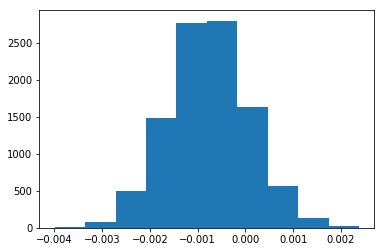

In [609]:
new_page_converted[50:60]
plt.hist(new_page_converted)
s = pd.Series(new_page_converted)
print('sample mean',s.mean())
print('sample standard deviation', s.std())
print('lower 2.5% confidence',np.percentile(s,2.5))
print('upper 97.5% confidence',np.percentile(s,97.5))
print('describe',s.describe())


f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

I made a new dataframe from n_old that only have the 'converted' values to use less computer memory. I then used the boot strap method to sample only n_old records and replace = true to have a new set of boot samples for each iteration. As instructed, I performed 10 000 iterations. I printed out each iteration so that I could follow the exectution of the iterations - this takes about 10-15 minutes because I do not have a business computer at home.

In [610]:
n_old_converted = n_old['converted']
old_page_converted = []
count = 0 
for _ in range(10000):
    boot_sample = n_old_converted.sample(len(n_old),replace=True)
    sample_new = boot_sample.mean()
    old_page_converted.append(sample_new-p_old)
    count +=1
    print('running',count)

running 1
running 2
running 3
running 4
running 5
running 6
running 7
running 8
running 9
running 10
running 11
running 12
running 13
running 14
running 15
running 16
running 17
running 18
running 19
running 20
running 21
running 22
running 23
running 24
running 25
running 26
running 27
running 28
running 29
running 30
running 31
running 32
running 33
running 34
running 35
running 36
running 37
running 38
running 39
running 40
running 41
running 42
running 43
running 44
running 45
running 46
running 47
running 48
running 49
running 50
running 51
running 52
running 53
running 54
running 55
running 56
running 57
running 58
running 59
running 60
running 61
running 62
running 63
running 64
running 65
running 66
running 67
running 68
running 69
running 70
running 71
running 72
running 73
running 74
running 75
running 76
running 77
running 78
running 79
running 80
running 81
running 82
running 83
running 84
running 85
running 86
running 87
running 88
running 89
running 90
running 91
running 

running 695
running 696
running 697
running 698
running 699
running 700
running 701
running 702
running 703
running 704
running 705
running 706
running 707
running 708
running 709
running 710
running 711
running 712
running 713
running 714
running 715
running 716
running 717
running 718
running 719
running 720
running 721
running 722
running 723
running 724
running 725
running 726
running 727
running 728
running 729
running 730
running 731
running 732
running 733
running 734
running 735
running 736
running 737
running 738
running 739
running 740
running 741
running 742
running 743
running 744
running 745
running 746
running 747
running 748
running 749
running 750
running 751
running 752
running 753
running 754
running 755
running 756
running 757
running 758
running 759
running 760
running 761
running 762
running 763
running 764
running 765
running 766
running 767
running 768
running 769
running 770
running 771
running 772
running 773
running 774
running 775
running 776
running 777
runn

running 1355
running 1356
running 1357
running 1358
running 1359
running 1360
running 1361
running 1362
running 1363
running 1364
running 1365
running 1366
running 1367
running 1368
running 1369
running 1370
running 1371
running 1372
running 1373
running 1374
running 1375
running 1376
running 1377
running 1378
running 1379
running 1380
running 1381
running 1382
running 1383
running 1384
running 1385
running 1386
running 1387
running 1388
running 1389
running 1390
running 1391
running 1392
running 1393
running 1394
running 1395
running 1396
running 1397
running 1398
running 1399
running 1400
running 1401
running 1402
running 1403
running 1404
running 1405
running 1406
running 1407
running 1408
running 1409
running 1410
running 1411
running 1412
running 1413
running 1414
running 1415
running 1416
running 1417
running 1418
running 1419
running 1420
running 1421
running 1422
running 1423
running 1424
running 1425
running 1426
running 1427
running 1428
running 1429
running 1430
running 1431

running 1987
running 1988
running 1989
running 1990
running 1991
running 1992
running 1993
running 1994
running 1995
running 1996
running 1997
running 1998
running 1999
running 2000
running 2001
running 2002
running 2003
running 2004
running 2005
running 2006
running 2007
running 2008
running 2009
running 2010
running 2011
running 2012
running 2013
running 2014
running 2015
running 2016
running 2017
running 2018
running 2019
running 2020
running 2021
running 2022
running 2023
running 2024
running 2025
running 2026
running 2027
running 2028
running 2029
running 2030
running 2031
running 2032
running 2033
running 2034
running 2035
running 2036
running 2037
running 2038
running 2039
running 2040
running 2041
running 2042
running 2043
running 2044
running 2045
running 2046
running 2047
running 2048
running 2049
running 2050
running 2051
running 2052
running 2053
running 2054
running 2055
running 2056
running 2057
running 2058
running 2059
running 2060
running 2061
running 2062
running 2063

running 2620
running 2621
running 2622
running 2623
running 2624
running 2625
running 2626
running 2627
running 2628
running 2629
running 2630
running 2631
running 2632
running 2633
running 2634
running 2635
running 2636
running 2637
running 2638
running 2639
running 2640
running 2641
running 2642
running 2643
running 2644
running 2645
running 2646
running 2647
running 2648
running 2649
running 2650
running 2651
running 2652
running 2653
running 2654
running 2655
running 2656
running 2657
running 2658
running 2659
running 2660
running 2661
running 2662
running 2663
running 2664
running 2665
running 2666
running 2667
running 2668
running 2669
running 2670
running 2671
running 2672
running 2673
running 2674
running 2675
running 2676
running 2677
running 2678
running 2679
running 2680
running 2681
running 2682
running 2683
running 2684
running 2685
running 2686
running 2687
running 2688
running 2689
running 2690
running 2691
running 2692
running 2693
running 2694
running 2695
running 2696

running 3252
running 3253
running 3254
running 3255
running 3256
running 3257
running 3258
running 3259
running 3260
running 3261
running 3262
running 3263
running 3264
running 3265
running 3266
running 3267
running 3268
running 3269
running 3270
running 3271
running 3272
running 3273
running 3274
running 3275
running 3276
running 3277
running 3278
running 3279
running 3280
running 3281
running 3282
running 3283
running 3284
running 3285
running 3286
running 3287
running 3288
running 3289
running 3290
running 3291
running 3292
running 3293
running 3294
running 3295
running 3296
running 3297
running 3298
running 3299
running 3300
running 3301
running 3302
running 3303
running 3304
running 3305
running 3306
running 3307
running 3308
running 3309
running 3310
running 3311
running 3312
running 3313
running 3314
running 3315
running 3316
running 3317
running 3318
running 3319
running 3320
running 3321
running 3322
running 3323
running 3324
running 3325
running 3326
running 3327
running 3328

running 3883
running 3884
running 3885
running 3886
running 3887
running 3888
running 3889
running 3890
running 3891
running 3892
running 3893
running 3894
running 3895
running 3896
running 3897
running 3898
running 3899
running 3900
running 3901
running 3902
running 3903
running 3904
running 3905
running 3906
running 3907
running 3908
running 3909
running 3910
running 3911
running 3912
running 3913
running 3914
running 3915
running 3916
running 3917
running 3918
running 3919
running 3920
running 3921
running 3922
running 3923
running 3924
running 3925
running 3926
running 3927
running 3928
running 3929
running 3930
running 3931
running 3932
running 3933
running 3934
running 3935
running 3936
running 3937
running 3938
running 3939
running 3940
running 3941
running 3942
running 3943
running 3944
running 3945
running 3946
running 3947
running 3948
running 3949
running 3950
running 3951
running 3952
running 3953
running 3954
running 3955
running 3956
running 3957
running 3958
running 3959

running 4517
running 4518
running 4519
running 4520
running 4521
running 4522
running 4523
running 4524
running 4525
running 4526
running 4527
running 4528
running 4529
running 4530
running 4531
running 4532
running 4533
running 4534
running 4535
running 4536
running 4537
running 4538
running 4539
running 4540
running 4541
running 4542
running 4543
running 4544
running 4545
running 4546
running 4547
running 4548
running 4549
running 4550
running 4551
running 4552
running 4553
running 4554
running 4555
running 4556
running 4557
running 4558
running 4559
running 4560
running 4561
running 4562
running 4563
running 4564
running 4565
running 4566
running 4567
running 4568
running 4569
running 4570
running 4571
running 4572
running 4573
running 4574
running 4575
running 4576
running 4577
running 4578
running 4579
running 4580
running 4581
running 4582
running 4583
running 4584
running 4585
running 4586
running 4587
running 4588
running 4589
running 4590
running 4591
running 4592
running 4593

running 5150
running 5151
running 5152
running 5153
running 5154
running 5155
running 5156
running 5157
running 5158
running 5159
running 5160
running 5161
running 5162
running 5163
running 5164
running 5165
running 5166
running 5167
running 5168
running 5169
running 5170
running 5171
running 5172
running 5173
running 5174
running 5175
running 5176
running 5177
running 5178
running 5179
running 5180
running 5181
running 5182
running 5183
running 5184
running 5185
running 5186
running 5187
running 5188
running 5189
running 5190
running 5191
running 5192
running 5193
running 5194
running 5195
running 5196
running 5197
running 5198
running 5199
running 5200
running 5201
running 5202
running 5203
running 5204
running 5205
running 5206
running 5207
running 5208
running 5209
running 5210
running 5211
running 5212
running 5213
running 5214
running 5215
running 5216
running 5217
running 5218
running 5219
running 5220
running 5221
running 5222
running 5223
running 5224
running 5225
running 5226

running 5782
running 5783
running 5784
running 5785
running 5786
running 5787
running 5788
running 5789
running 5790
running 5791
running 5792
running 5793
running 5794
running 5795
running 5796
running 5797
running 5798
running 5799
running 5800
running 5801
running 5802
running 5803
running 5804
running 5805
running 5806
running 5807
running 5808
running 5809
running 5810
running 5811
running 5812
running 5813
running 5814
running 5815
running 5816
running 5817
running 5818
running 5819
running 5820
running 5821
running 5822
running 5823
running 5824
running 5825
running 5826
running 5827
running 5828
running 5829
running 5830
running 5831
running 5832
running 5833
running 5834
running 5835
running 5836
running 5837
running 5838
running 5839
running 5840
running 5841
running 5842
running 5843
running 5844
running 5845
running 5846
running 5847
running 5848
running 5849
running 5850
running 5851
running 5852
running 5853
running 5854
running 5855
running 5856
running 5857
running 5858

running 6417
running 6418
running 6419
running 6420
running 6421
running 6422
running 6423
running 6424
running 6425
running 6426
running 6427
running 6428
running 6429
running 6430
running 6431
running 6432
running 6433
running 6434
running 6435
running 6436
running 6437
running 6438
running 6439
running 6440
running 6441
running 6442
running 6443
running 6444
running 6445
running 6446
running 6447
running 6448
running 6449
running 6450
running 6451
running 6452
running 6453
running 6454
running 6455
running 6456
running 6457
running 6458
running 6459
running 6460
running 6461
running 6462
running 6463
running 6464
running 6465
running 6466
running 6467
running 6468
running 6469
running 6470
running 6471
running 6472
running 6473
running 6474
running 6475
running 6476
running 6477
running 6478
running 6479
running 6480
running 6481
running 6482
running 6483
running 6484
running 6485
running 6486
running 6487
running 6488
running 6489
running 6490
running 6491
running 6492
running 6493

running 7052
running 7053
running 7054
running 7055
running 7056
running 7057
running 7058
running 7059
running 7060
running 7061
running 7062
running 7063
running 7064
running 7065
running 7066
running 7067
running 7068
running 7069
running 7070
running 7071
running 7072
running 7073
running 7074
running 7075
running 7076
running 7077
running 7078
running 7079
running 7080
running 7081
running 7082
running 7083
running 7084
running 7085
running 7086
running 7087
running 7088
running 7089
running 7090
running 7091
running 7092
running 7093
running 7094
running 7095
running 7096
running 7097
running 7098
running 7099
running 7100
running 7101
running 7102
running 7103
running 7104
running 7105
running 7106
running 7107
running 7108
running 7109
running 7110
running 7111
running 7112
running 7113
running 7114
running 7115
running 7116
running 7117
running 7118
running 7119
running 7120
running 7121
running 7122
running 7123
running 7124
running 7125
running 7126
running 7127
running 7128

running 7685
running 7686
running 7687
running 7688
running 7689
running 7690
running 7691
running 7692
running 7693
running 7694
running 7695
running 7696
running 7697
running 7698
running 7699
running 7700
running 7701
running 7702
running 7703
running 7704
running 7705
running 7706
running 7707
running 7708
running 7709
running 7710
running 7711
running 7712
running 7713
running 7714
running 7715
running 7716
running 7717
running 7718
running 7719
running 7720
running 7721
running 7722
running 7723
running 7724
running 7725
running 7726
running 7727
running 7728
running 7729
running 7730
running 7731
running 7732
running 7733
running 7734
running 7735
running 7736
running 7737
running 7738
running 7739
running 7740
running 7741
running 7742
running 7743
running 7744
running 7745
running 7746
running 7747
running 7748
running 7749
running 7750
running 7751
running 7752
running 7753
running 7754
running 7755
running 7756
running 7757
running 7758
running 7759
running 7760
running 7761

running 8322
running 8323
running 8324
running 8325
running 8326
running 8327
running 8328
running 8329
running 8330
running 8331
running 8332
running 8333
running 8334
running 8335
running 8336
running 8337
running 8338
running 8339
running 8340
running 8341
running 8342
running 8343
running 8344
running 8345
running 8346
running 8347
running 8348
running 8349
running 8350
running 8351
running 8352
running 8353
running 8354
running 8355
running 8356
running 8357
running 8358
running 8359
running 8360
running 8361
running 8362
running 8363
running 8364
running 8365
running 8366
running 8367
running 8368
running 8369
running 8370
running 8371
running 8372
running 8373
running 8374
running 8375
running 8376
running 8377
running 8378
running 8379
running 8380
running 8381
running 8382
running 8383
running 8384
running 8385
running 8386
running 8387
running 8388
running 8389
running 8390
running 8391
running 8392
running 8393
running 8394
running 8395
running 8396
running 8397
running 8398

running 8954
running 8955
running 8956
running 8957
running 8958
running 8959
running 8960
running 8961
running 8962
running 8963
running 8964
running 8965
running 8966
running 8967
running 8968
running 8969
running 8970
running 8971
running 8972
running 8973
running 8974
running 8975
running 8976
running 8977
running 8978
running 8979
running 8980
running 8981
running 8982
running 8983
running 8984
running 8985
running 8986
running 8987
running 8988
running 8989
running 8990
running 8991
running 8992
running 8993
running 8994
running 8995
running 8996
running 8997
running 8998
running 8999
running 9000
running 9001
running 9002
running 9003
running 9004
running 9005
running 9006
running 9007
running 9008
running 9009
running 9010
running 9011
running 9012
running 9013
running 9014
running 9015
running 9016
running 9017
running 9018
running 9019
running 9020
running 9021
running 9022
running 9023
running 9024
running 9025
running 9026
running 9027
running 9028
running 9029
running 9030

running 9585
running 9586
running 9587
running 9588
running 9589
running 9590
running 9591
running 9592
running 9593
running 9594
running 9595
running 9596
running 9597
running 9598
running 9599
running 9600
running 9601
running 9602
running 9603
running 9604
running 9605
running 9606
running 9607
running 9608
running 9609
running 9610
running 9611
running 9612
running 9613
running 9614
running 9615
running 9616
running 9617
running 9618
running 9619
running 9620
running 9621
running 9622
running 9623
running 9624
running 9625
running 9626
running 9627
running 9628
running 9629
running 9630
running 9631
running 9632
running 9633
running 9634
running 9635
running 9636
running 9637
running 9638
running 9639
running 9640
running 9641
running 9642
running 9643
running 9644
running 9645
running 9646
running 9647
running 9648
running 9649
running 9650
running 9651
running 9652
running 9653
running 9654
running 9655
running 9656
running 9657
running 9658
running 9659
running 9660
running 9661

# Curious about the results 
This was not required, but I converted the list into a series and made a historgram.  By converting into a series, 
I could get statstics and look at confidence intervals. As expected, more users convert used the old page, but the 
difference from the population means is very small  (.0008094.) 

sample mean 0.0008093764030068059
sample standard deviation 0.0008484175241066898
lower 2.5% confidence -0.000807937087363
upper 97.5% confidence 0.00248256912848
describe count    10000.000000
mean         0.000809
std          0.000848
min         -0.003100
25%          0.000225
50%          0.000796
75%          0.001388
max          0.003873
dtype: float64


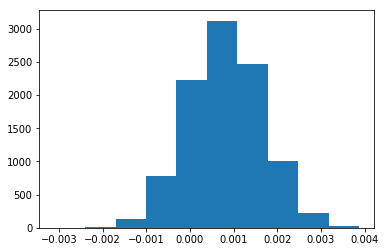

In [611]:

plt.hist(old_page_converted)
t = pd.Series(old_page_converted)
print('sample mean',t.mean())
print('sample standard deviation', t.std())
print('lower 2.5% confidence',np.percentile(t,2.5))
print('upper 97.5% confidence',np.percentile(t,97.5))
print('describe',t.describe())


g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

I have calcualted -0.00158 convert using the new page

In [612]:
new_null = s.mean() - t.mean()
new_null

-0.0015798371253962426

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

I return to my original hypothesis.
P null: old page conversions > = new page converstions, P alternative: new page conversions > old page conversions

I sample from the whole dataframe, but I make two dataframes from the random sample: old_df and new_df. I then calculated a converted mean for each dataframe.  I append to the p_diffs_list2 the difference between the old_page converted mean and new_page converted mean. 

To save computer memory I made a sampling dataframe.  I also have a for statement print so that I can know the progress of my for statement. 

I got the idea to do this from the Udacity Completion rate excercise. 

In [613]:
df2_converted = df2[['landing_page','converted']]
p_diffs_list2 = []
count = 0 
for _ in range(10000):
    boot_sample = df2_converted.sample(len(df2),replace=True)
    old_df = boot_sample.query('landing_page == "old_page"')
    new_df = boot_sample.query('landing_page == "new_page"')
    old_mean = old_df['converted'].mean()
    new_mean = new_df['converted'].mean()
    p_diffs_list2.append(new_mean-old_mean)
    count +=1
    print('running',count)

running 1
running 2
running 3
running 4
running 5
running 6
running 7
running 8
running 9
running 10
running 11
running 12
running 13
running 14
running 15
running 16
running 17
running 18
running 19
running 20
running 21
running 22
running 23
running 24
running 25
running 26
running 27
running 28
running 29
running 30
running 31
running 32
running 33
running 34
running 35
running 36
running 37
running 38
running 39
running 40
running 41
running 42
running 43
running 44
running 45
running 46
running 47
running 48
running 49
running 50
running 51
running 52
running 53
running 54
running 55
running 56
running 57
running 58
running 59
running 60
running 61
running 62
running 63
running 64
running 65
running 66
running 67
running 68
running 69
running 70
running 71
running 72
running 73
running 74
running 75
running 76
running 77
running 78
running 79
running 80
running 81
running 82
running 83
running 84
running 85
running 86
running 87
running 88
running 89
running 90
running 91
running 

running 693
running 694
running 695
running 696
running 697
running 698
running 699
running 700
running 701
running 702
running 703
running 704
running 705
running 706
running 707
running 708
running 709
running 710
running 711
running 712
running 713
running 714
running 715
running 716
running 717
running 718
running 719
running 720
running 721
running 722
running 723
running 724
running 725
running 726
running 727
running 728
running 729
running 730
running 731
running 732
running 733
running 734
running 735
running 736
running 737
running 738
running 739
running 740
running 741
running 742
running 743
running 744
running 745
running 746
running 747
running 748
running 749
running 750
running 751
running 752
running 753
running 754
running 755
running 756
running 757
running 758
running 759
running 760
running 761
running 762
running 763
running 764
running 765
running 766
running 767
running 768
running 769
running 770
running 771
running 772
running 773
running 774
running 775
runn

running 1347
running 1348
running 1349
running 1350
running 1351
running 1352
running 1353
running 1354
running 1355
running 1356
running 1357
running 1358
running 1359
running 1360
running 1361
running 1362
running 1363
running 1364
running 1365
running 1366
running 1367
running 1368
running 1369
running 1370
running 1371
running 1372
running 1373
running 1374
running 1375
running 1376
running 1377
running 1378
running 1379
running 1380
running 1381
running 1382
running 1383
running 1384
running 1385
running 1386
running 1387
running 1388
running 1389
running 1390
running 1391
running 1392
running 1393
running 1394
running 1395
running 1396
running 1397
running 1398
running 1399
running 1400
running 1401
running 1402
running 1403
running 1404
running 1405
running 1406
running 1407
running 1408
running 1409
running 1410
running 1411
running 1412
running 1413
running 1414
running 1415
running 1416
running 1417
running 1418
running 1419
running 1420
running 1421
running 1422
running 1423

running 1978
running 1979
running 1980
running 1981
running 1982
running 1983
running 1984
running 1985
running 1986
running 1987
running 1988
running 1989
running 1990
running 1991
running 1992
running 1993
running 1994
running 1995
running 1996
running 1997
running 1998
running 1999
running 2000
running 2001
running 2002
running 2003
running 2004
running 2005
running 2006
running 2007
running 2008
running 2009
running 2010
running 2011
running 2012
running 2013
running 2014
running 2015
running 2016
running 2017
running 2018
running 2019
running 2020
running 2021
running 2022
running 2023
running 2024
running 2025
running 2026
running 2027
running 2028
running 2029
running 2030
running 2031
running 2032
running 2033
running 2034
running 2035
running 2036
running 2037
running 2038
running 2039
running 2040
running 2041
running 2042
running 2043
running 2044
running 2045
running 2046
running 2047
running 2048
running 2049
running 2050
running 2051
running 2052
running 2053
running 2054

running 2609
running 2610
running 2611
running 2612
running 2613
running 2614
running 2615
running 2616
running 2617
running 2618
running 2619
running 2620
running 2621
running 2622
running 2623
running 2624
running 2625
running 2626
running 2627
running 2628
running 2629
running 2630
running 2631
running 2632
running 2633
running 2634
running 2635
running 2636
running 2637
running 2638
running 2639
running 2640
running 2641
running 2642
running 2643
running 2644
running 2645
running 2646
running 2647
running 2648
running 2649
running 2650
running 2651
running 2652
running 2653
running 2654
running 2655
running 2656
running 2657
running 2658
running 2659
running 2660
running 2661
running 2662
running 2663
running 2664
running 2665
running 2666
running 2667
running 2668
running 2669
running 2670
running 2671
running 2672
running 2673
running 2674
running 2675
running 2676
running 2677
running 2678
running 2679
running 2680
running 2681
running 2682
running 2683
running 2684
running 2685

running 3240
running 3241
running 3242
running 3243
running 3244
running 3245
running 3246
running 3247
running 3248
running 3249
running 3250
running 3251
running 3252
running 3253
running 3254
running 3255
running 3256
running 3257
running 3258
running 3259
running 3260
running 3261
running 3262
running 3263
running 3264
running 3265
running 3266
running 3267
running 3268
running 3269
running 3270
running 3271
running 3272
running 3273
running 3274
running 3275
running 3276
running 3277
running 3278
running 3279
running 3280
running 3281
running 3282
running 3283
running 3284
running 3285
running 3286
running 3287
running 3288
running 3289
running 3290
running 3291
running 3292
running 3293
running 3294
running 3295
running 3296
running 3297
running 3298
running 3299
running 3300
running 3301
running 3302
running 3303
running 3304
running 3305
running 3306
running 3307
running 3308
running 3309
running 3310
running 3311
running 3312
running 3313
running 3314
running 3315
running 3316

running 3871
running 3872
running 3873
running 3874
running 3875
running 3876
running 3877
running 3878
running 3879
running 3880
running 3881
running 3882
running 3883
running 3884
running 3885
running 3886
running 3887
running 3888
running 3889
running 3890
running 3891
running 3892
running 3893
running 3894
running 3895
running 3896
running 3897
running 3898
running 3899
running 3900
running 3901
running 3902
running 3903
running 3904
running 3905
running 3906
running 3907
running 3908
running 3909
running 3910
running 3911
running 3912
running 3913
running 3914
running 3915
running 3916
running 3917
running 3918
running 3919
running 3920
running 3921
running 3922
running 3923
running 3924
running 3925
running 3926
running 3927
running 3928
running 3929
running 3930
running 3931
running 3932
running 3933
running 3934
running 3935
running 3936
running 3937
running 3938
running 3939
running 3940
running 3941
running 3942
running 3943
running 3944
running 3945
running 3946
running 3947

running 4502
running 4503
running 4504
running 4505
running 4506
running 4507
running 4508
running 4509
running 4510
running 4511
running 4512
running 4513
running 4514
running 4515
running 4516
running 4517
running 4518
running 4519
running 4520
running 4521
running 4522
running 4523
running 4524
running 4525
running 4526
running 4527
running 4528
running 4529
running 4530
running 4531
running 4532
running 4533
running 4534
running 4535
running 4536
running 4537
running 4538
running 4539
running 4540
running 4541
running 4542
running 4543
running 4544
running 4545
running 4546
running 4547
running 4548
running 4549
running 4550
running 4551
running 4552
running 4553
running 4554
running 4555
running 4556
running 4557
running 4558
running 4559
running 4560
running 4561
running 4562
running 4563
running 4564
running 4565
running 4566
running 4567
running 4568
running 4569
running 4570
running 4571
running 4572
running 4573
running 4574
running 4575
running 4576
running 4577
running 4578

running 5133
running 5134
running 5135
running 5136
running 5137
running 5138
running 5139
running 5140
running 5141
running 5142
running 5143
running 5144
running 5145
running 5146
running 5147
running 5148
running 5149
running 5150
running 5151
running 5152
running 5153
running 5154
running 5155
running 5156
running 5157
running 5158
running 5159
running 5160
running 5161
running 5162
running 5163
running 5164
running 5165
running 5166
running 5167
running 5168
running 5169
running 5170
running 5171
running 5172
running 5173
running 5174
running 5175
running 5176
running 5177
running 5178
running 5179
running 5180
running 5181
running 5182
running 5183
running 5184
running 5185
running 5186
running 5187
running 5188
running 5189
running 5190
running 5191
running 5192
running 5193
running 5194
running 5195
running 5196
running 5197
running 5198
running 5199
running 5200
running 5201
running 5202
running 5203
running 5204
running 5205
running 5206
running 5207
running 5208
running 5209

running 5764
running 5765
running 5766
running 5767
running 5768
running 5769
running 5770
running 5771
running 5772
running 5773
running 5774
running 5775
running 5776
running 5777
running 5778
running 5779
running 5780
running 5781
running 5782
running 5783
running 5784
running 5785
running 5786
running 5787
running 5788
running 5789
running 5790
running 5791
running 5792
running 5793
running 5794
running 5795
running 5796
running 5797
running 5798
running 5799
running 5800
running 5801
running 5802
running 5803
running 5804
running 5805
running 5806
running 5807
running 5808
running 5809
running 5810
running 5811
running 5812
running 5813
running 5814
running 5815
running 5816
running 5817
running 5818
running 5819
running 5820
running 5821
running 5822
running 5823
running 5824
running 5825
running 5826
running 5827
running 5828
running 5829
running 5830
running 5831
running 5832
running 5833
running 5834
running 5835
running 5836
running 5837
running 5838
running 5839
running 5840

running 6395
running 6396
running 6397
running 6398
running 6399
running 6400
running 6401
running 6402
running 6403
running 6404
running 6405
running 6406
running 6407
running 6408
running 6409
running 6410
running 6411
running 6412
running 6413
running 6414
running 6415
running 6416
running 6417
running 6418
running 6419
running 6420
running 6421
running 6422
running 6423
running 6424
running 6425
running 6426
running 6427
running 6428
running 6429
running 6430
running 6431
running 6432
running 6433
running 6434
running 6435
running 6436
running 6437
running 6438
running 6439
running 6440
running 6441
running 6442
running 6443
running 6444
running 6445
running 6446
running 6447
running 6448
running 6449
running 6450
running 6451
running 6452
running 6453
running 6454
running 6455
running 6456
running 6457
running 6458
running 6459
running 6460
running 6461
running 6462
running 6463
running 6464
running 6465
running 6466
running 6467
running 6468
running 6469
running 6470
running 6471

running 7026
running 7027
running 7028
running 7029
running 7030
running 7031
running 7032
running 7033
running 7034
running 7035
running 7036
running 7037
running 7038
running 7039
running 7040
running 7041
running 7042
running 7043
running 7044
running 7045
running 7046
running 7047
running 7048
running 7049
running 7050
running 7051
running 7052
running 7053
running 7054
running 7055
running 7056
running 7057
running 7058
running 7059
running 7060
running 7061
running 7062
running 7063
running 7064
running 7065
running 7066
running 7067
running 7068
running 7069
running 7070
running 7071
running 7072
running 7073
running 7074
running 7075
running 7076
running 7077
running 7078
running 7079
running 7080
running 7081
running 7082
running 7083
running 7084
running 7085
running 7086
running 7087
running 7088
running 7089
running 7090
running 7091
running 7092
running 7093
running 7094
running 7095
running 7096
running 7097
running 7098
running 7099
running 7100
running 7101
running 7102

running 7657
running 7658
running 7659
running 7660
running 7661
running 7662
running 7663
running 7664
running 7665
running 7666
running 7667
running 7668
running 7669
running 7670
running 7671
running 7672
running 7673
running 7674
running 7675
running 7676
running 7677
running 7678
running 7679
running 7680
running 7681
running 7682
running 7683
running 7684
running 7685
running 7686
running 7687
running 7688
running 7689
running 7690
running 7691
running 7692
running 7693
running 7694
running 7695
running 7696
running 7697
running 7698
running 7699
running 7700
running 7701
running 7702
running 7703
running 7704
running 7705
running 7706
running 7707
running 7708
running 7709
running 7710
running 7711
running 7712
running 7713
running 7714
running 7715
running 7716
running 7717
running 7718
running 7719
running 7720
running 7721
running 7722
running 7723
running 7724
running 7725
running 7726
running 7727
running 7728
running 7729
running 7730
running 7731
running 7732
running 7733

running 8288
running 8289
running 8290
running 8291
running 8292
running 8293
running 8294
running 8295
running 8296
running 8297
running 8298
running 8299
running 8300
running 8301
running 8302
running 8303
running 8304
running 8305
running 8306
running 8307
running 8308
running 8309
running 8310
running 8311
running 8312
running 8313
running 8314
running 8315
running 8316
running 8317
running 8318
running 8319
running 8320
running 8321
running 8322
running 8323
running 8324
running 8325
running 8326
running 8327
running 8328
running 8329
running 8330
running 8331
running 8332
running 8333
running 8334
running 8335
running 8336
running 8337
running 8338
running 8339
running 8340
running 8341
running 8342
running 8343
running 8344
running 8345
running 8346
running 8347
running 8348
running 8349
running 8350
running 8351
running 8352
running 8353
running 8354
running 8355
running 8356
running 8357
running 8358
running 8359
running 8360
running 8361
running 8362
running 8363
running 8364

running 8919
running 8920
running 8921
running 8922
running 8923
running 8924
running 8925
running 8926
running 8927
running 8928
running 8929
running 8930
running 8931
running 8932
running 8933
running 8934
running 8935
running 8936
running 8937
running 8938
running 8939
running 8940
running 8941
running 8942
running 8943
running 8944
running 8945
running 8946
running 8947
running 8948
running 8949
running 8950
running 8951
running 8952
running 8953
running 8954
running 8955
running 8956
running 8957
running 8958
running 8959
running 8960
running 8961
running 8962
running 8963
running 8964
running 8965
running 8966
running 8967
running 8968
running 8969
running 8970
running 8971
running 8972
running 8973
running 8974
running 8975
running 8976
running 8977
running 8978
running 8979
running 8980
running 8981
running 8982
running 8983
running 8984
running 8985
running 8986
running 8987
running 8988
running 8989
running 8990
running 8991
running 8992
running 8993
running 8994
running 8995

running 9550
running 9551
running 9552
running 9553
running 9554
running 9555
running 9556
running 9557
running 9558
running 9559
running 9560
running 9561
running 9562
running 9563
running 9564
running 9565
running 9566
running 9567
running 9568
running 9569
running 9570
running 9571
running 9572
running 9573
running 9574
running 9575
running 9576
running 9577
running 9578
running 9579
running 9580
running 9581
running 9582
running 9583
running 9584
running 9585
running 9586
running 9587
running 9588
running 9589
running 9590
running 9591
running 9592
running 9593
running 9594
running 9595
running 9596
running 9597
running 9598
running 9599
running 9600
running 9601
running 9602
running 9603
running 9604
running 9605
running 9606
running 9607
running 9608
running 9609
running 9610
running 9611
running 9612
running 9613
running 9614
running 9615
running 9616
running 9617
running 9618
running 9619
running 9620
running 9621
running 9622
running 9623
running 9624
running 9625
running 9626

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

I make a histogram from the p_diff_list2 list and convert it into a series so that I make some statistics. 

The plot does look as expected - it is normally distribued. The results confirm that there is conversion using the new_page because the sample mean is -.001599 representing the -1,59% were less converted using the new_page. 

sample mean -0.0015987756940696214
sample standard deviation 0.001184168919431753
lower 2.5% confidence -0.00389570774005
upper 97.5% confidence 0.000716956413321
describe count    10000.000000
mean        -0.001599
std          0.001184
min         -0.005856
25%         -0.002400
50%         -0.001602
75%         -0.000796
max          0.002790
dtype: float64


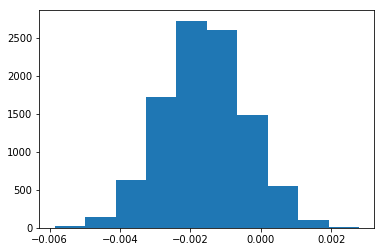

In [614]:
plt.hist(p_diffs_list2)
u = pd.Series(p_diffs_list2)
print('sample mean',u.mean())
print('sample standard deviation', u.std())
print('lower 2.5% confidence',np.percentile(u,2.5))
print('upper 97.5% confidence',np.percentile(u,97.5))
print('describe',u.describe())

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

The calculated pvalue is .91.  



null values mean -2.12994445811e-06
actual difference mean -0.0015782389853555567


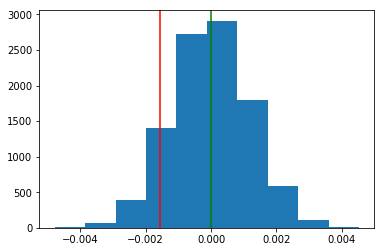

In [615]:
null_vals = np.random.normal(0,u.std(),len(u))
actual_difference = df2.query('landing_page == "new_page"') ['converted'].mean() - df2.query('landing_page == "old_page"') ['converted'].mean()

# Plot the null distribution
# plot line for observed statistic

plt.hist(null_vals)
plt.axvline(x=actual_difference,color = 'red')
plt.axvline(x=null_vals.mean(),color = 'green')
print('null values mean', null_vals.mean())
print('actual difference mean',actual_difference)

In [616]:
# compute p value
pvalue = (null_vals > actual_difference).mean()
pvalue


0.90969999999999995

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

 

**Put your answer here.**


# The pval>α⇒ Fail to Reject the Null Hypothesis". I read through the internet to understand what is a p value. I liked this article: http://trendingsideways.com/index.php/the-p-value-formula-testing-your-hypothesis/ . 
# To me in simpler English, I would say that the P value means that I can continue data analysis if I "Fail to Reject the Null Hypothesis".  But it says nothing about the statistic itself - should I use the old or new payget. What it says is that I can look at the confidence intervals. 

# Then I continued to read the internet to understand what I have done for the P value calculation. Ironically, the answer was right in front of my nose right here: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a45f86_dand-syllabus-v7-terms-1/dand-syllabus-v7-terms-1.pdf . I believe I have confirmed that I have learned to perform a T test: https://en.wikipedia.org/wiki/Student%27s_t-test . This is a fun article - Udacity could add it to the lecture, but it look like Udacity wants us to find this for ourselves. 


# As I reflected on this more, the hypothesis is proven for 10 000 random selection simulations of the data set.  From the law of large numbers, we can be pretty convinced about this population. But the user can and will change.  This is why, business people will regularly want to monitor results. For example, a marketing campaign could change the types of users that we are reaching and could result in different results then expected.  

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

# I start with calculating proportions. 

In [617]:
import statsmodels.api as sm

convert_old = len(df2.query('group =="control" and converted ==1'))
convert_new = len(df2.query('group =="treatment" and converted ==1'))
n_old_count = len(n_old)
n_new_count = len(n_new)
print('old converstion',convert_old/n_old_count)
print('new converstion',convert_new/n_new_count)
print(convert_old,convert_new,n_old_count,n_new_count)




old converstion 0.1203863045004612
new converstion 0.11880806551510564
17489 17264 145274 145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

# The calculated Z score is 1.311 and the Z score acceptance range is from .905 to 1.95996.  I was puzzled that the alternative value does not change the Z value, but as I think about that more it is bcause the alternative values is all about the null hypotheses.   We can Fail to Reject the null hypothesis because the P value of .19 is greater than 0 - I got this from a 5% confidence and one degree of freedom from this table: https://people.smp.uq.edu.au/YoniNazarathy/stat_models_B_course_spring_07/distributions/chisqtab.pdf.  

In [618]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import norm


counts = np.array([convert_old, convert_new])
nobs = np.array([n_old_count, n_new_count])


#z_score, pval = proportions_ztest(counts, nobs, alternative='larger')
z_score, pval = proportions_ztest(counts, nobs)
print('{0:0.3f}'.format(z_score))
print('{0:0.10f}'.format(pval))
norm.cdf(z_score)
print(norm.cdf(z_score))
# 0.9999999383005862 # Tells us how significant our z-score is

norm.ppf(1-(0.05/2))
print(norm.ppf(1-(0.05/2)))
# 1.959963984540054 # Tells us what our critical value at 95% confidence is

1.311
0.1898833745
0.905058312759
1.95996398454


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?  

**Put your answer here.**

# In J we calculated a Test Test.  In K, we calcualted a chi square.  That is why I look at the chi square table to validate the p value. 

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Put your answer here.**

Logistic regression 

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

# I make a df3 dataframe. I make dummies making new_page as my value and and intercept. 

In [619]:
df3 = df2
df3.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [620]:

df3['new_page'] = pd.get_dummies(df['landing_page'])['new_page'] # I want to now use new_page to see I should use it  
df3['intercept'] = 1 
df3.head()



,user_id,timestamp,group,landing_page,converted,new_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [621]:
log_mod = sm.Logit(df3['converted'], df3[['intercept', 'new_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [622]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 15 Feb 2018   Pseudo R-squ.:               8.077e-06
Time:                        23:36:22   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
new_page      -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [623]:
# to interpet the logical regression results, the variable need to be exponeted, if negative needs to divide 1 by the 
#exponent
# old page is .985 times less likely to be convert 
1/np.exp(.0150)

0.98511193960306276

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Put your answer here.**

The Z value is now with the opposite sign with the proportions_ztest because I am using new_page with my intercept value. The P value is different from part two bacause I can now see that sm.Logit use also the chi square for calculating the p value - just like the proportions_ztest - the p value match.  The logistic regression also confirms that the new page shold not be used .985 times likely conversion.   

I have learned when drawing conclusions you need to be skeptical - this I have also learned in my business life.  Now we have used 3 different methods to confirm or test results: we have used logistic regression, the proportions_ztest, and the T test. In all instances we have confirmed that we should stick with the old page.  

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

# Adding other factors can give a better understanding of the statistical results.  For example extra data from cookies could be added. Adding too many factors may make the model hard to understand.  You also need to be careful that the X vairables are not related, but that they are independent of one another.  This is where the regression models P scores can help. 

**Put your answer here.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question. I will answer step by step. 

In [655]:
country = 'C:/Users/Kims/Documents/Data_Analysis_2017/statistics/a_b/countries.csv'

countries_df = pd.read_csv(country)

countries_df.head()


,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


# Before getting started with analysis 
I want to look at the data quality 

There are no duplicated records, and no null records. 

Data uniquness is as expected, there are three countries in the dataframe (I looked at this in an excel. There are 290 584 records which matched df2 - so the join should work as expected.

In [625]:
# 1) check for duplicates 
print('duplicated', sum(countries_df.duplicated()))
# 2) check for nulls and remove nulls, this is good for python but also for analysis, I do not want to analyze incomplete
# data 
print('look at nulls',countries_df.info()) 
# 3) check for uniqueness
print('uniqueness',countries_df.nunique())

duplicated 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 2 columns):
user_id    290584 non-null int64
country    290584 non-null object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB
look at nulls None
uniqueness user_id    290584
country         3
dtype: int64


# join countries to df_new

In [656]:

df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted
user_id,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0


# I was curious about how the countries affected the logistic regression analysis so I make 3 dataframes. 

In [657]:
### Create the necessary dummy variables
df_new1 = df_new.copy()
df_new1['new_page'] = pd.get_dummies(df_new1['landing_page'])['new_page'] # this is how to get the weekday without dropping weekend
df_new1['intercept'] = 1
df_new1['UK'] = pd.get_dummies(df_new1['country']) ['UK']
df_new1['CA'] = pd.get_dummies(df_new1['country']) ['CA']
df_new1.head()




,country,timestamp,group,landing_page,converted,new_page,intercept,UK,CA
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0


In [658]:
### Create the necessary dummy variables
df_new2 = df_new.copy()
df_new2['new_page'] = pd.get_dummies(df_new2['landing_page'])['new_page'] # this is how to get the weekday without dropping weekend
df_new2['intercept'] = 1
df_new2['US'] = pd.get_dummies(df_new2['country']) ['US']
df_new2['CA'] = pd.get_dummies(df_new2['country']) ['CA']
df_new2.head()




,country,timestamp,group,landing_page,converted,new_page,intercept,US,CA
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0


In [661]:
### Create the necessary dummy variables
df_new3 = df_new.copy()
df_new3['new_page'] = pd.get_dummies(df_new3['landing_page'])['new_page'] # this is how to get the weekday without dropping weekend
df_new3['intercept'] = 1
df_new3['US'] = pd.get_dummies(df_new3['country']) ['US']
df_new3['UK'] = pd.get_dummies(df_new3['country']) ['UK']
df_new3.head()




,country,timestamp,group,landing_page,converted,new_page,intercept,US,UK
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [662]:
### Fit Your Linear Model And Obtain the Results
log_mod = sm.Logit(df_new1['converted'], df_new1[['intercept', 'new_page','UK','CA']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 15 Feb 2018   Pseudo R-squ.:               2.323e-05
Time:                        23:49:46   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
new_page      -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
==============================================================================
"""

In [663]:
# to interpet the logical regression results, the variable need to be exponeted, if negative needs to divide 1 by the 
#exponent
1/np.exp(.0149),np.exp(.0099),1/np.exp(.0408)

(0.9852104557227469, 1.0099491671175422, 0.96002111497165088)

# the old_page conversion rate stays at 1.05.  The UK has a .01 conversion rate, but Canada had a .96 conversion rate. 

In [664]:
### Fit Your Linear Model And Obtain the Results
log_mod = sm.Logit(df_new2['converted'], df_new2[['intercept', 'new_page','US','CA']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 15 Feb 2018   Pseudo R-squ.:               2.323e-05
Time:                        23:50:33   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9794      0.013   -155.415      0.000      -2.004      -1.954
new_page      -0.0149      0.011     -1.307      0.191      -0.037       0.007
US            -0.0099      0.013     -0.743      0.457      -0.036       0.016
CA            -0.0506      0.028     -1.784      0.074      -0.106       0.005
==============================================================================
"""

In [665]:
# to interpet the logical regression results, the variable need to be exponeted, if negative needs to divide 1 by the 
#exponent
1/np.exp(.0149),1/np.exp(.0099),1/np.exp(.0506)

(0.9852104557227469, 0.99014884368295708, 0.95065885803307093)

# When you put the US and Canada together, the US has a .99 conversion rate while Canada has a .95 conversion rate.  I was starting to think maybe the new_page would work in other countries better. 

In [666]:
### Fit Your Linear Model And Obtain the Results
log_mod = sm.Logit(df_new3['converted'], df_new3[['intercept', 'new_page','US','UK']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 15 Feb 2018   Pseudo R-squ.:               2.323e-05
Time:                        23:51:10   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
new_page      -0.0149      0.011     -1.307      0.191      -0.037       0.007
US             0.0408      0.027      1.516      0.130      -0.012       0.093
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
==============================================================================
"""

In [667]:
# to interpet the logical regression results, the variable need to be exponeted, if negative needs to divide 1 by the 
#exponent
1/np.exp(.0149),np.exp(.0408),np.exp(.0506)

(0.9852104557227469, 1.0416437559600236, 1.0519020483004984)

# When you analyze the US and UK together, you can see that the US has a 1.042 conversion rate, while the UK has a 1.052 conversion rate. 

In [668]:
print('Number of UK unique users',len(df_new.query('country == "UK"'))) 
print('Number of CA unique users',len(df_new.query('country == "CA"')))
print('Number of US unique users',len(df_new.query('country == "US"')))
#df_new.query('country == "CA"')['converted'].mean()
print('Mean of Canada old_page converted',df_new.query('country == "CA" and landing_page == "old_page"') ['converted'].mean())
print('Mean of Canada new_page converted',df_new.query('country == "CA" and landing_page == "new_page"') ['converted'].mean())
print('Mean of UK old_page converted',df_new.query('country == "UK" and landing_page == "old_page"') ['converted'].mean())
print('Mean of UK new_page converted',df_new.query('country == "UK" and landing_page == "new_page"') ['converted'].mean())
print('Mean of US old_page converted',df_new.query('country == "US" and landing_page == "old_page"') ['converted'].mean())
print('Mean of US new_page converted',df_new.query('country == "US" and landing_page == "new_page"') ['converted'].mean())

Number of UK unique users 72466
Number of CA unique users 14499
Number of US unique users 203619
Mean of Canada old_page converted 0.11878299527646569
Mean of Canada new_page converted 0.11190247911245035
Mean of UK old_page converted 0.12002200220022002
Mean of UK new_page converted 0.1211709965102753
Mean of US old_page converted 0.12062998938220143
Mean of US new_page converted 0.11846559963887227


# I decided to make statistics for the dataframe joined with country. Canada has 14 499 users, but Canada also has the lowest conversion rates.  11.9% for the old page and 11.2% for the new_page. 

# UK has 72466 users, and the  UK the has conversion rates of 12.0% for the old page and 12.1% for the new_page. The new_page is very marginally better.  


# US has 203 619 users, and the  Us the has conversion rates of 12.1% for the old page and 11.85% for the new_page.

# There are country difference, but it looks the new new page will not help us in other countries. 

<a id='conclusions'></a>
## Conclusions

Congratulations on completing the project! 

### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.